In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
from matplotlib.colors import ListedColormap

from utils.permitivity_level_set import LevelSetSIREN
from utils.permitivity_level_set import get_dolphin_points


2025-08-14 08:46:03.619373: W external/xla/xla/service/platform_util.cc:206] unable to create StreamExecutor for CUDA:0: : CUDA_ERROR_OUT_OF_MEMORY: out of memory


In [2]:

negative_points_dophin, positive_points_dophin = get_dolphin_points(mesh_density=250)
np.savez('tmp/points_dolphin.npz', 
         negative_points=negative_points_dophin,
         positive_points=positive_points_dophin)


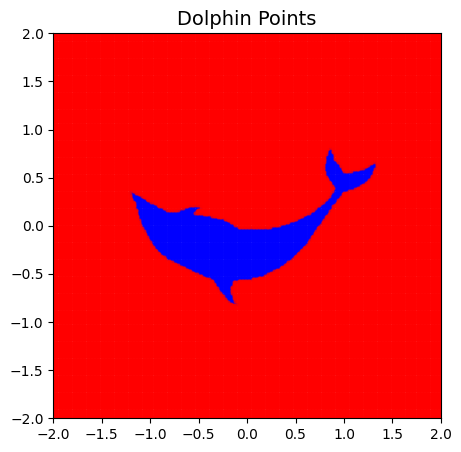

In [12]:
data = np.load('tmp/points_dolphin.npz')
negative_points_dophin = data['negative_points']
positive_points_dophin = data['positive_points']
plt.figure(figsize=(5,5))
plt.title('Dolphin Points', fontsize=14)
plt.scatter(negative_points_dophin[:, 0]*2, negative_points_dophin[:, 1]*2, s=4, c='blue', alpha=0.6)
plt.scatter(positive_points_dophin[:, 0]*2, positive_points_dophin[:, 1]*2, s=4, c='red', alpha=0.6)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.show()

In [47]:

# Create and train model
model = LevelSetSIREN(omega_0=30, neurons=[2, 128, 128, 128, 128, 1])
print("Training model...")
trained_params = model.train(
    negative_points_dophin*2, positive_points_dophin*2, 
    alpha_gradient=1e-4, alpha_smoothness=1e-7, 
    num_epochs=1001
)

# Save the trained model
model.save_model("models/circle_level_set_model.pkl")


Training model...
Epoch:     1, time: 5.7408, L_magnitude: 2.3607e-04, L_gradient: 7.5699e-01, L_smoothness: 4.1608e+01
Epoch:   251, time: 0.0371, L_magnitude: 4.3335e-09, L_gradient: 1.2603e-03, L_smoothness: 4.3531e-01
Epoch:   501, time: 0.0355, L_magnitude: 3.6545e-09, L_gradient: 1.2683e-03, L_smoothness: 3.7661e-01
Epoch:   751, time: 0.0355, L_magnitude: 3.0854e-09, L_gradient: 1.2694e-03, L_smoothness: 3.5503e-01
Epoch:  1001, time: 0.0373, L_magnitude: 2.4305e-09, L_gradient: 1.2733e-03, L_smoothness: 3.3770e-01
Model saved to models/circle_level_set_model.pkl


Model loaded from models/circle_level_set_model.pkl


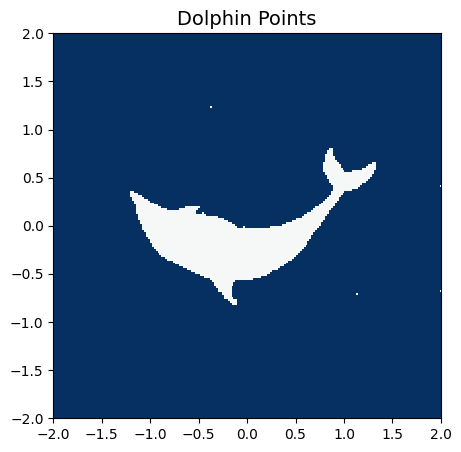

In [13]:

# Load model
loaded_model = LevelSetSIREN.from_file("models/circle_level_set_model.pkl")

nx = 200
plt.figure(figsize=(5,5))
plt.title('Dolphin Points', fontsize=14)

x_plot = jnp.linspace(-2, 2, nx)
y_plot = jnp.linspace(-2, 2, nx)
X, Y = jnp.meshgrid(x_plot, y_plot)
points = jnp.stack((X.flatten(), Y.flatten()), axis=1)
q = loaded_model.predict_level_set(points)
plt.pcolormesh(X, Y, (q>0).reshape((nx, nx)), cmap='RdBu', shading='auto', vmin=-1e-2, vmax=1e-2)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.show()

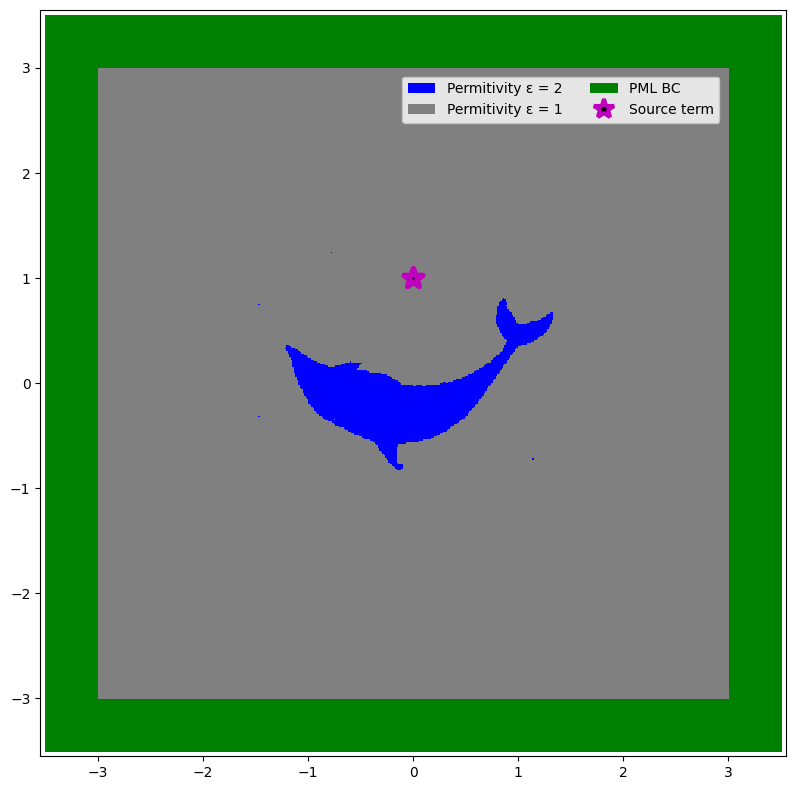

: 

In [ ]:

def classify_point(loaded_model, point):
    """
    Classify point(s) with the following logic:
    - Add +0.75 to y component 
    - Return 2 if SHIFTED point is outside [-3,3] square (domain 2, PML)
    - Return 1 if SHIFTED point is between [-2,2] and [-3,3] (domain 1, epsilon = 1)
    - Return 0 if SHIFTED point is in [-2,2] AND level set < 0 (domain 0, epsilon = 2)
    - Return 1 if SHIFTED point is in [-2,2] AND level set >= 0 (domain 1, epsilon = 1)
    """
    point = jnp.array(point)
    if point.ndim == 1:
        point = point.reshape(1, -1)
    
    # Shift y component up by 0.75
    shifted_points = point.copy()
    shifted_points = shifted_points.at[:, 1].add(0.0)
    
    # Check different regions based on SHIFTED points
    outside_3x3 = ~jnp.all((point >= -3) & (point <= 3), axis=1)
    inside_2x2 = jnp.all((shifted_points >= -1.5) & (shifted_points <= 1.5), axis=1)
    between_boxes = ~outside_3x3 & ~inside_2x2  # In [-3,3] but outside [-2,2]
    
    # Initialize result array
    result = jnp.full(len(point), 1)  # Default to 1
    
    # Set points outside [-3,3] box to 2 (PML)
    result = result.at[outside_3x3].set(2)
    
    # Set points between [-2,2] and [-3,3] to 1 (keep as 1)
    result = result.at[between_boxes].set(1)
    
    # For points inside [-2,2], classify based on level set
    if jnp.any(inside_2x2):
        inside_shifted_points = shifted_points[inside_2x2]
        level_values = loaded_model.predict_level_set(inside_shifted_points).flatten()
        
        # Classify based on level set: 0 if negative, 1 if positive
        inside_classifications = jnp.where(level_values < 0, 0, 1)
        result = result.at[inside_2x2].set(inside_classifications)
    
    return result if len(result) > 1 else result[0]

# Plotting parameters
nx = 500  # Adjust as needed
x_plot = jnp.linspace(-3.5, 3.5, nx)
y_plot = jnp.linspace(-3.5, 3.5, nx)
X, Y = jnp.meshgrid(x_plot, y_plot)
points = jnp.stack((X.flatten(), Y.flatten()), axis=1)

# Get classifications
classifications = classify_point(loaded_model, points)

# Create custom colormap for the three domains
colors = ['blue', 'gray', 'green']  # 0: blue, 1: red, 2: green
cmap = ListedColormap(colors)

# Create the plot
plt.figure(figsize=(8.06, 8.))
im = plt.pcolormesh(X, Y, classifications.reshape((nx, nx)), 
                    cmap=cmap, shading='auto', vmin=0, vmax=2)

# Add source point at (0, 1) - BLACK STAR
plt.scatter(0, 1, c='black', s=200, marker='*', edgecolors='m', linewidth=4, zorder=10)

# Add legend
legend_labels = ['Permitivity ε = 2', 'Permitivity ε = 1', 'PML BC']
legend_colors = colors

# Create legend patches
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Patch(facecolor=colors[i], label=legend_labels[i]) for i in range(3)]

# Add source point to legend
source_element = Line2D([0], [0], marker='*', color='w', markerfacecolor='black', 
                       markeredgecolor='m', markeredgewidth=3, markersize=15, 
                       label='Source term', linestyle='None')
legend_elements.append(source_element)

plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.92, 0.92), ncol=2)

# Make plot square and adjust layout
plt.axis('equal')
plt.xlim(-3.5, 3.5)
plt.xticks(np.arange(-3, 4, 1))
plt.ylim(-3.5, 3.5)
plt.yticks(np.arange(-3, 4, 1))
plt.tight_layout()
plt.savefig(f'../../Latex/Figs/task1/domain.png')

